In [1]:
import librosa
import librosa.display
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import cv2 as cv  # OpenCV

In [2]:
speach_path = "../dataset/sr/clips"
noice_path = "../dataset/noise_dataset/audio/fold8"

fs = 16e3 # Hz sampling frequency
windowLength = 256
fftLength = windowLength
overlap = round(0.25 * windowLength) # overlap of 75%
window = scipy.signal.hamming(windowLength, sym=False)

In [3]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    #Normalization?
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr

def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noise_segment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise_segment ** 2)
    noisy_audio = clean_audio + np.sqrt(speech_power / noise_power) * noise_segment
    return noisy_audio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Min: -0.33333334 Max: 0.30629855


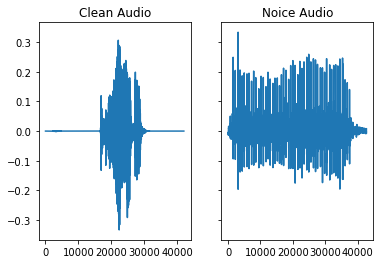

In [4]:
clean_audio, sampl_rate_clean = read_audio(os.path.join(speach_path, 'common_voice_sr_26874228.mp3'), sample_rate=fs)
noice_audio, sampl_rate_noice = read_audio(os.path.join(noice_path, '33340-7-2-0.wav'), sample_rate=fs)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(clean_audio)
ax1.set_title("Clean Audio")

ax2.plot(noice_audio)
ax2.set_title("Noice Audio")

print("Min:", np.min(clean_audio),"Max:",np.max(clean_audio))

#librosa.stft(cleanAudio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)


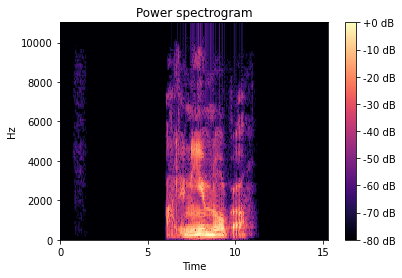

In [5]:
clean_audio_stft = librosa.stft(clean_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
clean_audio_stft_abs = np.abs(clean_audio_stft)
clean_audio_stft_abs_db = librosa.amplitude_to_db(clean_audio_stft_abs,ref=np.max)


fig, ax = plt.subplots()
img = librosa.display.specshow(clean_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

ipd.Audio(data=clean_audio, rate=sampl_rate_clean) # load a local WAV file

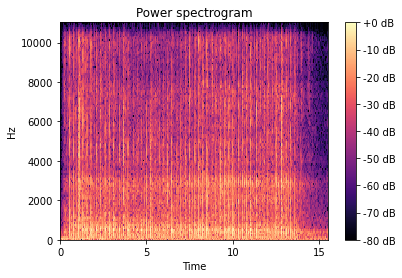

In [6]:
noice_audio_stft = librosa.stft(noice_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
noice_audio_stft_abs = np.abs(noice_audio_stft)
noice_audio_stft_abs_db = librosa.amplitude_to_db(noice_audio_stft_abs,ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(noice_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


ipd.Audio(data=noice_audio, rate=sampl_rate_noice) # load a local WAV file

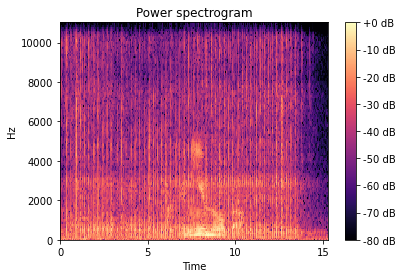

In [7]:
noice_and_audio = add_noise_to_clean_audio(clean_audio, noice_audio)

noice_and_audio_stft = librosa.stft(noice_and_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
noice_and_audio_stft_abs = np.abs(noice_and_audio_stft)
noice_and_audio_stft_abs_db = librosa.amplitude_to_db(noice_and_audio_stft_abs,ref=np.max)


fig, ax = plt.subplots()
img = librosa.display.specshow(noice_and_audio_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

ipd.Audio(data=noice_and_audio, rate=sampl_rate_clean) 